# Height Above Ground
Let's begin to play around with filters.

Start by importing various packages.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pdal
from sklearn.neighbors.kde import KernelDensity

And define our function for plotting the kernel density estimation for a particular dimension.

In [2]:
def dim_kde_full(arr, n=500, bw=0.25, k='epanechnikov'):
    xp = np.linspace(arr.min(), arr.max(), n)[:, np.newaxis]
    kde = KernelDensity(kernel=k, bandwidth=bw).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    plt.plot(xp, np.exp(log_pdf))

In [3]:
def dim_kde(arr, lb, ub, n=500, bw=0.25, k='epanechnikov'):
    f = plt.figure()
    xp = np.linspace(lb, ub, n)[:, np.newaxis]
    kde = KernelDensity(kernel=k, bandwidth=bw).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    ax = f.add_subplot(111)
    ax.plot(xp, np.exp(log_pdf))

The first pipeline will apply the Simple Morphological Filter (SMRF) to segment ground (`Classification=2`) and non-ground (`Classification=1`). Next, the Height Above Ground (HAG) filter is applied to estimate each point's height above ground. This is done by compute the difference in elevation between the current point and the nearest ground point (searching only laterally).

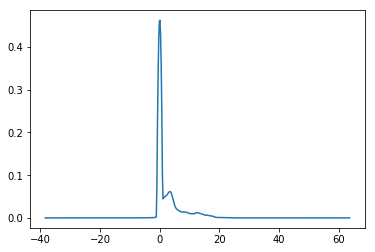

In [4]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    }
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde_full(data['HeightAboveGround'],bw=1.0)

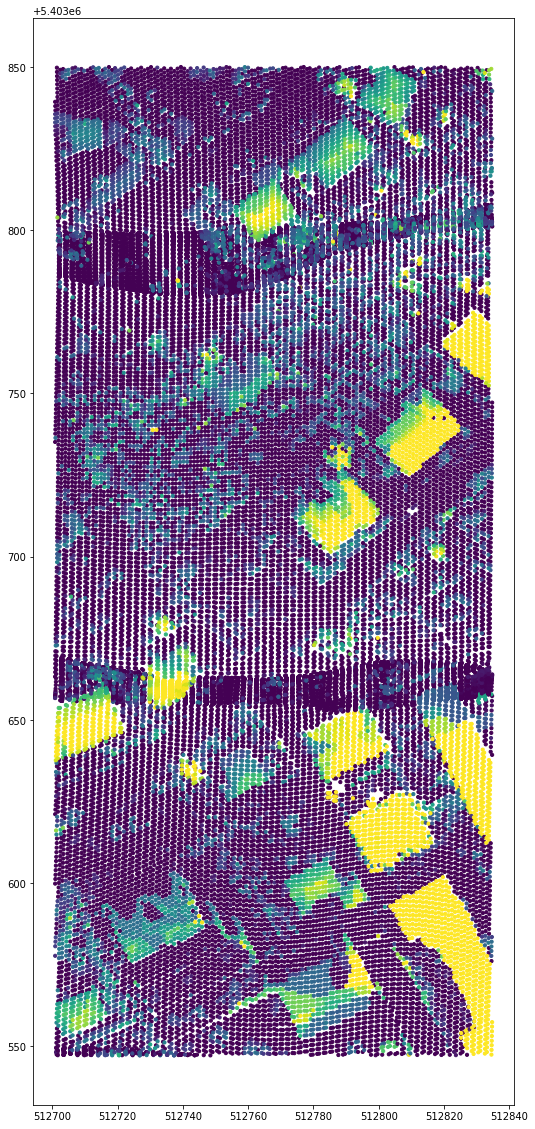

In [5]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['Y'],c=data['HeightAboveGround'],
           vmin=np.percentile(data['HeightAboveGround'],5),
           vmax=np.percentile(data['HeightAboveGround'],95),
           cmap='viridis', s=10)

We see that the range of HAG values can be quite large, and that there is a large spike at 0. This corresponds to the ground returns themselves, where the HAG is 0. We may be more interested in visualizing the HAG of only the non-ground points. Adding a range filter that passes points with `Classification=1` accomplishes this.

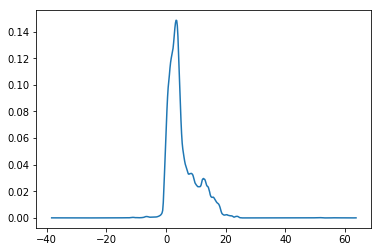

In [6]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    }
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde_full(data['HeightAboveGround'],bw=1.0)

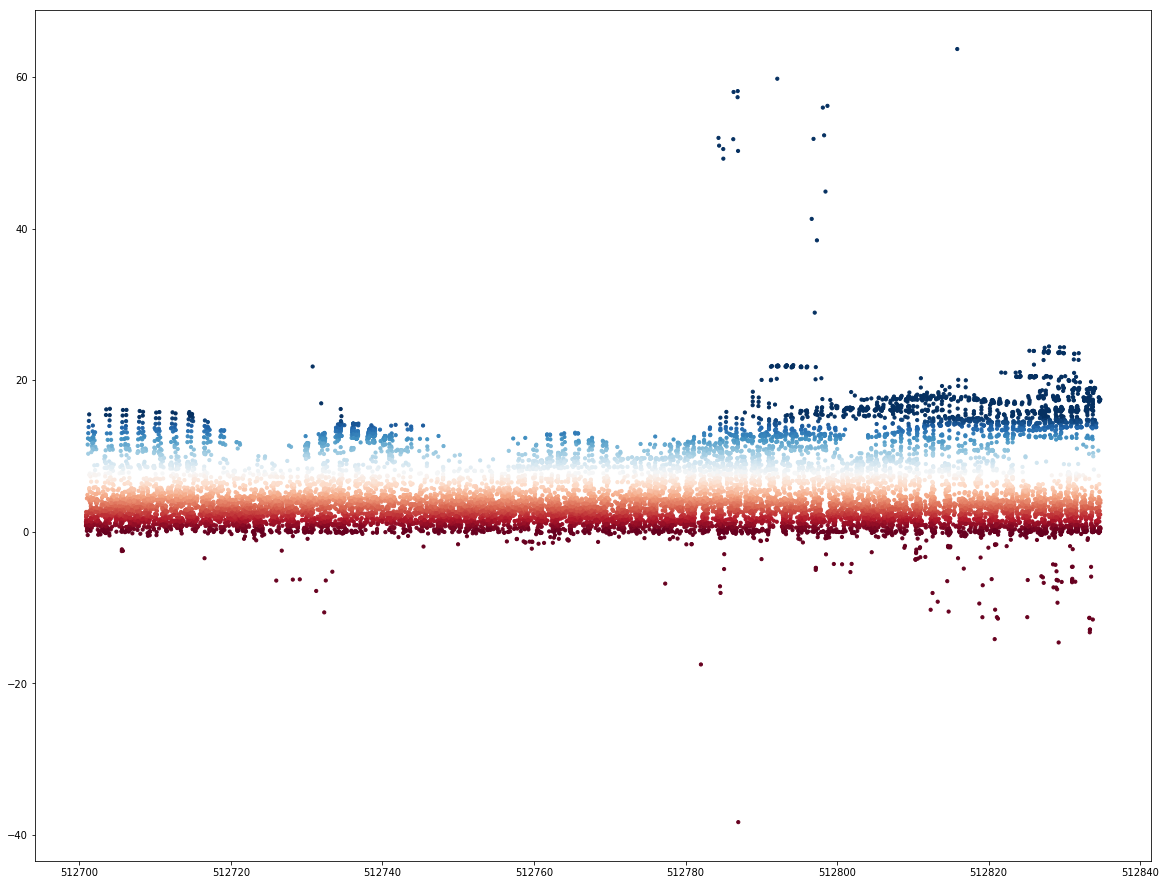

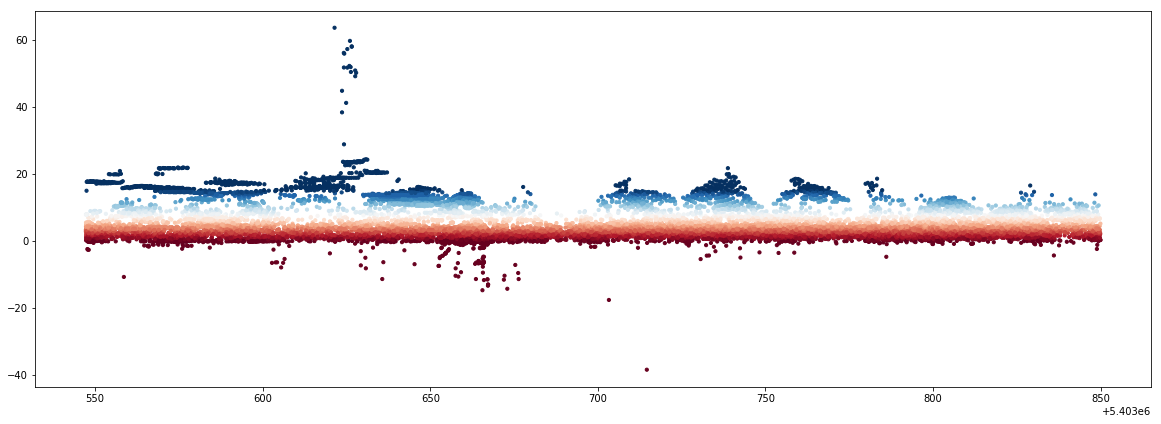

In [7]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['HeightAboveGround'],c=data['HeightAboveGround'],
           vmin=np.percentile(data['HeightAboveGround'],5),
           vmax=np.percentile(data['HeightAboveGround'],95),
           cmap='RdBu', s=10)

fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['Y'],data['HeightAboveGround'],c=data['HeightAboveGround'],
           vmin=np.percentile(data['HeightAboveGround'],5),
           vmax=np.percentile(data['HeightAboveGround'],95),
           cmap='RdBu', s=10)

Not sure this will work, but let's check to see if there appear to be a large number of low outliers.

In [8]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.elm"
    },
    {
      "type":"filters.range",
      "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    }
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
p.loglevel = 8
count = p.execute()
# print(count, 'points labeled as low outliers')
data = p.arrays[0]
log = p.log
print(log)
# dim_kde_full(data['HeightAboveGround'],bw=1.0)

(pypipeline filters.elm Info) Classified 54 points as noise by Extended Local Minimum (ELM).
(pypipeline filters.smrf Debug) progressiveFilter: radius = 1	40437 ground	165 non-ground	(0.41%)
(pypipeline filters.smrf Debug) progressiveFilter: radius = 1	28417 ground	12185 non-ground	(30.01%)
(pypipeline filters.smrf Debug) progressiveFilter: radius = 2	24905 ground	15697 non-ground	(38.66%)
(pypipeline filters.smrf Debug) progressiveFilter: radius = 3	23548 ground	17054 non-ground	(42.00%)
(pypipeline filters.smrf Debug) progressiveFilter: radius = 4	22810 ground	17792 non-ground	(43.82%)
(pypipeline filters.smrf Debug) progressiveFilter: radius = 5	22254 ground	18348 non-ground	(45.19%)
(pypipeline filters.smrf Debug) progressiveFilter: radius = 6	21636 ground	18966 non-ground	(46.71%)
(pypipeline filters.smrf Debug) progressiveFilter: radius = 7	20752 ground	19850 non-ground	(48.89%)
(pypipeline filters.smrf Debug) progressiveFilter: radius = 8	19922 ground	20680 non-ground	(50.93%)
(

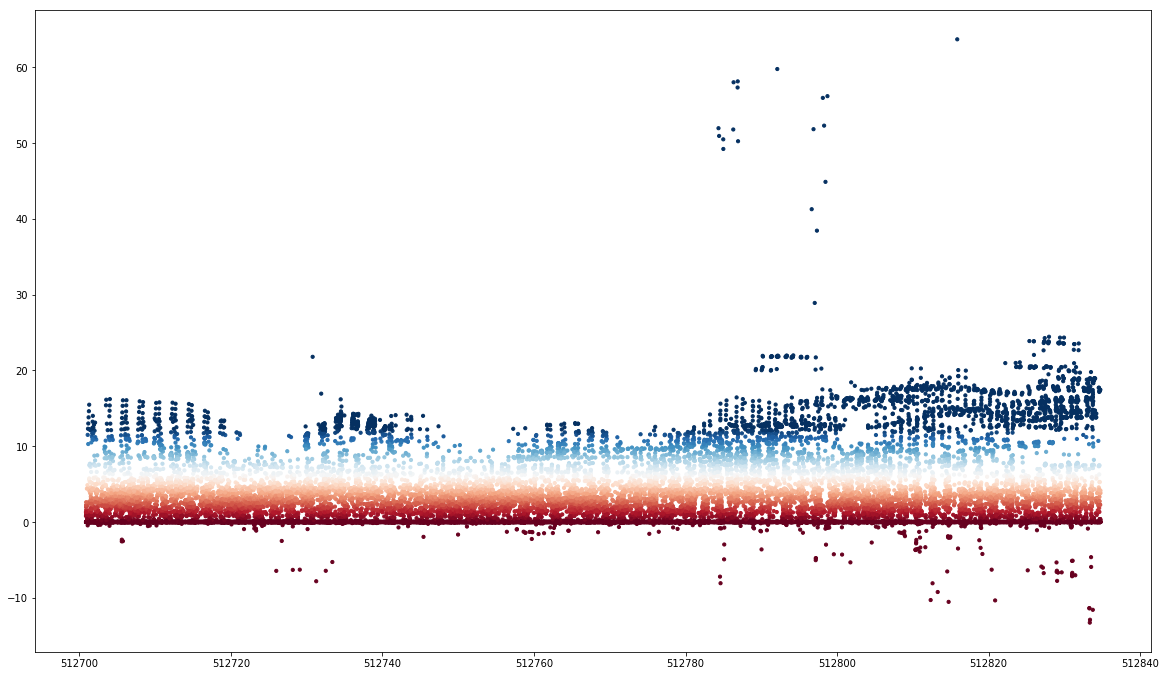

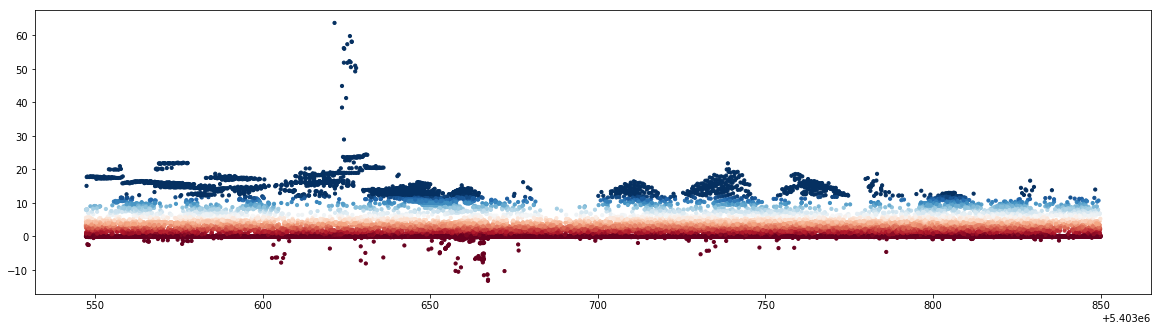

In [9]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['HeightAboveGround'],c=data['HeightAboveGround'],
           vmin=np.percentile(data['HeightAboveGround'],5),
           vmax=np.percentile(data['HeightAboveGround'],95),
           cmap='RdBu', s=10)

fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['Y'],data['HeightAboveGround'],c=data['HeightAboveGround'],
           vmin=np.percentile(data['HeightAboveGround'],5),
           vmax=np.percentile(data['HeightAboveGround'],95),
           cmap='RdBu', s=10)

That certainly may be something, let's remove these points and continue with the pipeline. Notice that we have not only added the `elm` and `range` filters, but we've now negated the `DimRange` indicating that we want to proceed with only the points that are **not** low outliers.

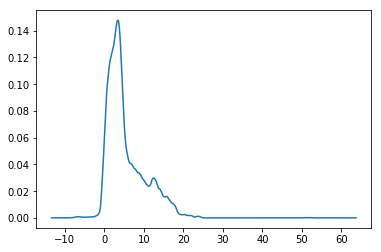

In [10]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.elm"
    },
    {
      "type":"filters.range",
      "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    }
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde_full(data['HeightAboveGround'],bw=1.0)

This is beginning to look better. Even now, we may be more interested in positive HAG values. Furthermore, let's cut out those points that are "near" ground. We will pass only those points with a HAG greater than 1.

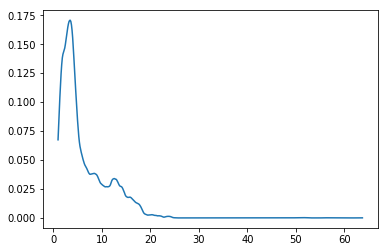

In [11]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1],HeightAboveGround[1:]"
    }
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde_full(data['HeightAboveGround'],bw=1.0)

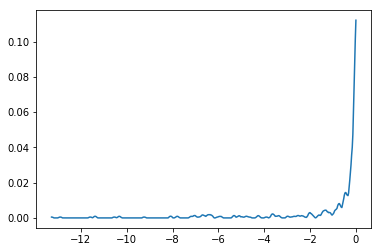

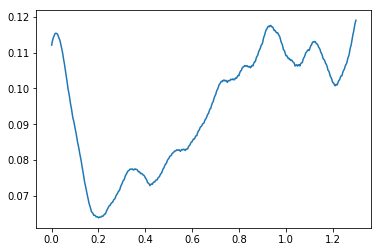

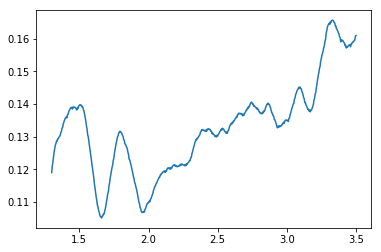

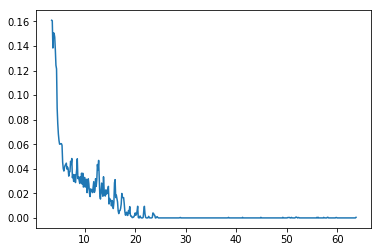

In [12]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.elm"
    },
    {
      "type":"filters.range",
      "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    }
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde(data['HeightAboveGround'],data['HeightAboveGround'].min(),0,bw=0.1)
dim_kde(data['HeightAboveGround'],0,1.3,bw=0.1)
dim_kde(data['HeightAboveGround'],1.3,3.5,bw=0.1)
dim_kde(data['HeightAboveGround'],3.5,data['HeightAboveGround'].max(),bw=0.1)

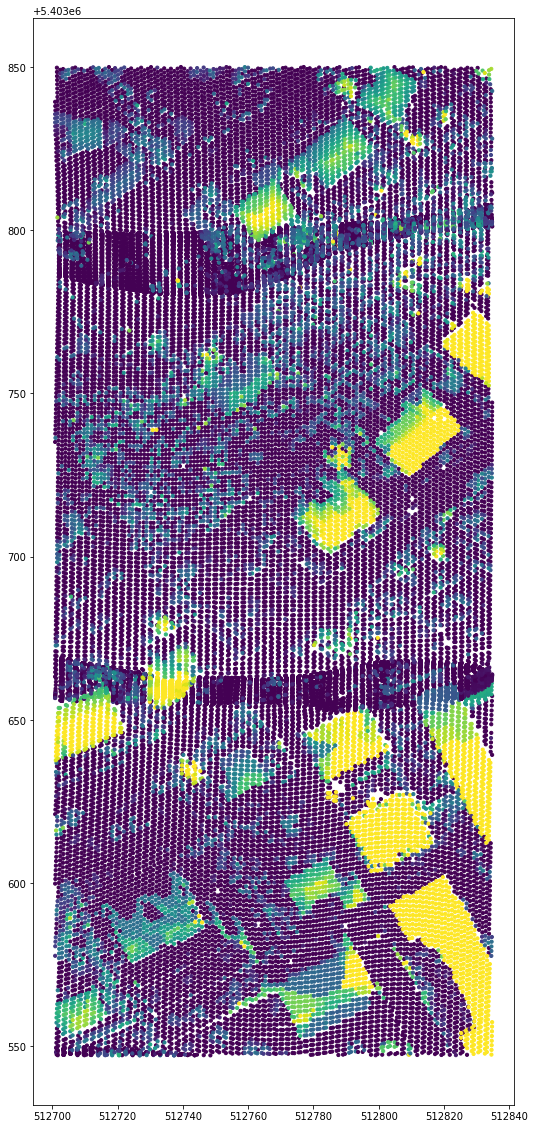

In [13]:
%matplotlib inline
# from mpl_toolkits import mplot3d
import matplotlib.colors as colors

json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.elm"
    },
    {
      "type":"filters.range",
      "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    }
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]

fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['Y'],c=data['HeightAboveGround'],
           vmin=np.percentile(data['HeightAboveGround'],5),
           vmax=np.percentile(data['HeightAboveGround'],95),
           cmap='viridis', s=10)